In [1]:
import cspython.match_dataset_creation
from cspython.merging_processing import combine_dfs
dir(cspython.match_dataset_creation)
from cspython.match_dataset_creation import match_dataset_creation
from cspython.match_dataset_creation import aggregate_data_over_time
import cPickle as pkl
from cspython.scraper import modifiedSoup
from cspython.data_processing import process_scrapped
import cPickle as pkl
import sys
sys.setrecursionlimit(15000)

import cspython.analysis as a
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
#import sklearn
#print('sklearn: {}'.format(sklearn.__version__))
#import xlrd

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline


import sklearn
print('sklearn: {}'.format(sklearn.__version__))
#import xlrd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn import preprocessing 
sns.set_style("whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pdb
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_selection import RFECV

scipy: 0.19.1
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.3
sklearn: 0.19.0


C:\Users\SuperBug\Anaconda2\envs\cs_project\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('../cspython/esl_teams.pkl', 'rb') as f: 
     d = pkl.load(f)

In [3]:
big_data = process_scrapped(d)
overview, big_data = big_data

In [4]:
data = combine_dfs(overview, big_data)

In [5]:
data = match_dataset_creation(data)

In [6]:
data = aggregate_data_over_time(data)

In [7]:
pd.set_option('display.max_columns', 300)

In [10]:
data.shape

(1208, 703)

In [1558]:
data.loc[(data.loc[:,'player_team_name'] == 'Cloud9') & (data.loc[:,'map'] == 'Inferno'),].sort_values(by='date',ascending=True)

,match_id,player_team_name,date,team_A_name,team_B_name,series_id,map,winner_of_match,loser_of_match,player_team_opponent,index,round_num,half,team_A,team_B,team_A_score,team_B_score,match_num,+/-,ADR,Rating2.0,seang@res_who_kill_who,SicK_who_kill_who,seang@res_awp_kills,SicK_awp_kills,devoduvek_first_kills,Slemmy_awp_kills,AmaNEk_first_kills,dephh_first_kills,ShahZaM_first_kills,AmaNEk_awp_kills,yay_awp_kills,ANDROID-X23_first_kills,ptr_who_kill_who,yay_first_kills,seang@res_first_kills,SicK_first_kills,dephh_awp_kills,ShahZaM_awp_kills,Slemmy_first_kills,ANDROID-X23_who_kill_who,devoduvek_awp_kills,Slemmy_who_kill_who,ANDROID-X23_awp_kills,ShahZaM_who_kill_who,devoduvek_who_kill_who,ptr_awp_kills,ptr_first_kills,yay_who_kill_who,dephh_who_kill_who,AmaNEk_who_kill_who,FalleN_first_kills,nitr0_who_kill_who,nitr0_awp_kills,fer_awp_kills,EliGE_first_kills,jdm64_awp_kills,FalleN_who_kill_who,Twistzz_who_kill_who,stanislaw_who_kill_who,felps_awp_kills,Twistzz_awp_kills,TACO_who_kill_who,jdm64_first_kills,fer_first_kills,coldzera_who_kill_who,coldzera_awp_kills,stanislaw_first_kills,EliGE_awp_kills,felps_first_kills,TACO_first_kills,fer_who_kill_who,felps_who_kill_who,Twistzz_first_kills,EliGE_who_kill_who,stanislaw_awp_kills,jdm64_who_kill_who,coldzera_first_kills,FalleN_awp_kills,nitr0_first_kills,TACO_awp_kills,jks_who_kill_who,Stewie2K_who_kill_who,NAF_awp_kills,Stewie2K_awp_kills,NAF_who_kill_who,NAF_first_kills,Nifty_first_kills,Nifty_who_kill_who,autimatic_awp_kills,RUSH_first_kills,RUSH_awp_kills,tarik_awp_kills,AZR_awp_kills,Skadoodle_first_kills,USTILO_awp_kills,Stewie2K_first_kills,tarik_who_kill_who,AZR_who_kill_who,tarik_first_kills,Skadoodle_who_kill_who,USTILO_first_kills,autimatic_who_kill_who,AZR_first_kills,Skadoodle_awp_kills,autimatic_first_kills,USTILO_who_kill_who,jks_first_kills,Nifty_awp_kills,jks_awp_kills,RUSH_who_kill_who,mixwell_who_kill_who,HS_awp_kills,friberg_awp_kills,allu_who_kill_who,mixwell_awp_kills,HS_first_kills,Magisk_awp_kills,Magisk_who_kill_who,Magisk_first_kills,mixwell_first_kills,allu_first_kills,allu_awp_kills,HS_who_kill_who,friberg_who_kill_who,friberg_first_kills,chelo_first_kills,PKL_awp_kills,yeL_awp_kills,NEKIZ_awp_kills,chelo_who_kill_who,SHOOWTiME_awp_kills,PKL_first_kills,SHOOWTiME_who_kill_who,PKL_who_kill_who,NEKIZ_first_kills,NEKIZ_who_kill_who,yeL_who_kill_who,yeL_first_kills,chelo_awp_kills,SHOOWTiME_first_kills,wrath_awp_kills,Hiko_awp_kills,cadiaN_awp_kills,wrath_first_kills,vice_first_kills,shinobi_first_kills,cadiaN_who_kill_who,vice_awp_kills,vice_who_kill_who,...,neptune_who_kill_who,neptune_awp_kills,ShoT_UP_who_kill_who,ShoT_UP_first_kills,n0thing_first_kills,n0thing_awp_kills,n0thing_who_kill_who,jasonR_awp_kills,jasonR_who_kill_who,jasonR_first_kills,valens_first_kills,valens_awp_kills,valens_who_kill_who,dead_awp_kills,dead_who_kill_who,dead_first_kills,Grt_first_kills,Grt_who_kill_who,Grt_awp_kills,stan1ey_first_kills,stan1ey_awp_kills,stan1ey_who_kill_who,Subroza_awp_kills,Subroza_first_kills,Subroza_who_kill_who,Relyks_first_kills,Relyks_who_kill_who,Relyks_awp_kills,SileNt_first_kills,SileNt_awp_kills,SileNt_who_kill_who,swag_first_kills,swag_who_kill_who,swag_awp_kills,first_kills_sum_dr,who_kill_who_sum_dr,awp_kills_sum_dr,AmaNEk,devoduvek,seang@res,ShahZaM,SicK,yay,dephh,ptr,ANDROID-X23,Slemmy,coldzera,fer,felps,FalleN,TACO,EliGE,jdm64,Twistzz,nitr0,stanislaw,NAF,USTILO,AZR,jks,Nifty,RUSH,Stewie2K,autimatic,tarik,Skadoodle,mixwell,HS,Magisk,allu,friberg,SHOOWTiME,yeL,NEKIZ,PKL,chelo,cadiaN,Hiko,wrath,vice,shinobi,zqkS,steel,destiny,horvy,zakk,seb,gMd,Wardell,bee,CONNOR93,boltz,LUCAS1,kNgV-,HEN1,Jayzwalkingz,Uber,witmer,CeRq,Brehze,AnJ,FugLy,daps,reltuC,Rickeh,FNS,nahtE,koosta,nexa,Warden,roca,XotiC,SEMPHIS,Drone,DAVEY,hazed,LILMAN,RIKO,zews,ryx,Dallas,m1tch,KHTEX,arya,shz,Surreal,desi,shroud,ShoT_UP,neptune,n0thing,jasonR,valens,dead,Grt,Subroza,stan1ey,Relyks,SileNt,swag,first_kills_sum_dr_hist,who_kill_who_sum_dr_hist,awp_kills_sum_dr_hist,matches_playe

In [11]:
#data.to_pickle("aggregated_dataset.pkl")


In [171]:
data = pd.read_pickle("aggregated_dataset.pkl")

In [172]:
data = data.drop(['team_A_name', 'team_B_name', 'index', 'round_num', 'team_A', 'team_B', 'team_A_score', 'team_B_score', 'half'], axis = 1)

In [173]:
def organize_team_data(data):
    data = data.sort_values(by=['date','match_num'],ascending=True) 
    for a in list(data.player_team_name.unique()):
        team_data = data.loc[(data.loc[:,'player_team_name'] == a),]
        data.loc[(data.loc[:,'player_team_name'] == a),'Cache_loss_his':'rounds_loss_vs_Cloud9_on_Nuke'] = data.loc[(data.loc[:,'player_team_name'] == a),'Cache_loss_his':'rounds_loss_vs_Cloud9_on_Nuke'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'first_kills_sum_dr_hist':'awp_kills_sum_dr_hist'] = data.loc[(data.loc[:,'player_team_name'] == a),'first_kills_sum_dr_hist':'awp_kills_sum_dr_hist'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'+/-':'awp_kills_sum_dr'] = data.loc[(data.loc[:,'player_team_name'] == a),'+/-':'awp_kills_sum_dr'].shift(1, axis = 0)
        data.loc[(data.loc[:,'player_team_name'] == a),'ADR_hist'] = data.loc[(data.loc[:,'player_team_name'] == a),'ADR_hist'].shift(1, axis = 0)
        for b in list(data.map.unique()):
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b), 'ADR_hist_on_map':'awp_kills_sum_dr_hist_on_map'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'map']==b), 'ADR_hist_on_map':'awp_kills_sum_dr_hist_on_map'].shift(1, axis = 0)
        for c in list(data.player_team_opponent.unique()):
            data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent']==c), 'matches_played_team'] = data.loc[(data.loc[:,'player_team_name'] == a) & (data.loc[:,'player_team_opponent']==c), 'matches_played_team'].shift(1, axis = 0)   
    return data

In [174]:
data = organize_team_data(data)

In [175]:
backup = data.player_team_name

In [176]:
data = pd.get_dummies(data,columns = ['player_team_name'])

In [177]:
data['player_team_name'] = backup

In [178]:
data.loc[:,data.columns != 'date'] = data.loc[:,data.columns != 'date'].apply(pd.to_numeric, errors='ignore')

In [179]:
data.loc[:,'player_team_name_CLG':'player_team_name_compLexity']=  data.loc[:,'player_team_name_CLG':'player_team_name_compLexity'].astype(np.int64)

In [180]:
data_even = data.iloc[::2]  # even
data_odd = data.iloc[1::2]
data_even = data_even.reset_index()
data_odd= data_odd.reset_index()

In [181]:
data_even.loc[:,'+/-':'player_team_name_compLexity'] = data_even.loc[:,'+/-':'player_team_name_compLexity'].subtract(data_odd.loc[:,'+/-':'player_team_name_compLexity'], axis = 1)

In [182]:
data_even = pd.get_dummies(data_even,columns = ['map'])

In [183]:
data_y = data_even.loc[:,['winner_of_match', 'player_team_name', 'match_id']]

In [184]:
data_even.loc[:,data_even.columns != 'date'] = data_even.loc[:,data_even.columns != 'date'].apply(pd.to_numeric, errors='ignore')


In [185]:
data_y.loc[data_y.winner_of_match != data_y.player_team_name, 'winner_of_match'] = 0
data_y.loc[data_y.winner_of_match == data_y.player_team_name, 'winner_of_match'] = 1


In [186]:
data_y.winner_of_match = data_y.winner_of_match.apply(pd.to_numeric, errors='ignore')

In [187]:
data_y = data_y.drop(['player_team_name','match_id'], axis = 1)

In [188]:
data_even = data_even.drop(['match_id'], axis = 1)

In [189]:
data_even = data_even.fillna(0)

In [190]:
data_even = data_even.round(4)

In [191]:
#only_team = data_even.player_team_name

In [192]:
#only_team = pd.get_dummies(only_team)

In [274]:
X = data_even.drop(data_even.loc[:,'seang@res_who_kill_who':'Relyks_awp_kills'].columns, axis = 1)

In [275]:
X = X.drop(['Nuke_loss_his', 'Nuke_win_his','Cache_win_his','Cobblestone_win_his', 'Inferno_win_his', 'Mirage_win_his'
            , 'Overpass_win_his', 'Train_win_his','Cache_loss_his','Cobblestone_loss_his', 'Inferno_loss_his', 'Mirage_loss_his'
            , 'Overpass_loss_his', 'Train_loss_his', 'index'], axis = 1)


In [195]:
for a in X.columns:
    print a

date
series_id
winner_of_match
loser_of_match
player_team_opponent
match_num
+/-
ADR
Rating2.0
first_kills_sum_dr
who_kill_who_sum_dr
awp_kills_sum_dr
devoduvek
seang@res
AmaNEk
SicK
ShahZaM
FugLy
Brehze
CeRq
daps
AnJ
USTILO
NAF
AZR
jks
Nifty
FalleN
felps
fer
coldzera
TACO
allu
mixwell
Magisk
friberg
HS
Rickeh
reltuC
nahtE
koosta
FNS
DAVEY
roca
Drone
m1tch
SEMPHIS
shroud
autimatic
Stewie2K
Skadoodle
n0thing
Wardell
ryx
seb
CONNOR93
bee
yeL
PKL
SHOOWTiME
NEKIZ
chelo
boltz
destiny
steel
horvy
zakk
ANDROID-X23
ptr
yay
dephh
Slemmy
LILMAN
RUSH
jasonR
tarik
nitr0
stanislaw
Twistzz
EliGE
jdm64
LUCAS1
kNgV-
HEN1
XotiC
cadiaN
Hiko
wrath
vice
shinobi
RIKO
nexa
Dallas
shz
zqkS
Jayzwalkingz
witmer
Uber
neptune
Grt
KHTEX
dead
Warden
Subroza
stan1ey
SileNt
zews
Surreal
desi
hazed
ShoT_UP
gMd
swag
arya
valens
Relyks
first_kills_sum_dr_hist
who_kill_who_sum_dr_hist
awp_kills_sum_dr_hist
matches_played_team
ADR_hist
ADR_hist_on_map
first_kills_sum_dr_hist_on_map
who_kill_who_sum_dr_hist_on_map
awp_kil

In [1499]:
#X = only_team

In [276]:
X = X.select_dtypes(include = ['int64', 'float64', 'uint8', 'bool']).iloc[:, 1:]

In [159]:
X.shape

(604, 380)

In [207]:
for a in X.columns:
    print a

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [1252]:
#data_adv_merged = pd.merge(data_adv_even, data_adv_odd, on =['match_id', 'date'])

In [1253]:
#data_adv_merged.loc[:,data_adv_merged.columns != 'date'] = data_adv_merged.loc[:,data_adv_merged.columns != 'date'].apply(pd.to_numeric, errors='ignore')

In [1254]:
#datay = data_adv_merged.loc[:,['winner_of_match_x', 'player_team_name_x', 'match_id']]

In [1255]:
#data_adv_merged = pd.get_dummies(data_adv_merged,columns = ['map_x'])

In [1256]:
#datay.loc[datay.winner_of_match_x != datay.player_team_name_x, 'winner_of_match_x'] = 0
#datay.loc[datay.winner_of_match_x == datay.player_team_name_x, 'winner_of_match_x'] = 1


In [1257]:
#datay.winner_of_match_x = datay.winner_of_match_x.apply(pd.to_numeric, errors='ignore')

In [1258]:
#datay = datay.drop(['player_team_name_x','match_id'], axis = 1)

In [1259]:
#data_adv_merged = data_adv_merged.drop(['match_id'], axis = 1)

In [1260]:
#data_adv_merged = data_adv_merged.round(4)

In [1261]:
#data_adv_temp = data_adv.loc[:,[,'Train_win_perc_map','Cobblestone_win_perc_map','Mirage_win_perc_map'
#                                ,'Cache_win_perc_map','Inferno_win_perc_map','Overpass_win_perc_map','Nuke_win_perc_map']]

In [162]:
def local_cv(model, params):                             #KFOLD WITH GRID SEARCH
    param_grid = params
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X, y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    for params, mean_score, scores in grid_result.grid_scores_:
        print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

In [266]:
X = X.iloc[:,top_95_important_features]

In [228]:
#X= data_even.drop('index', axis = 1)

In [222]:
for a in X.columns:
    print a

+/-
ADR
Rating2.0
first_kills_sum_dr
who_kill_who_sum_dr
awp_kills_sum_dr
devoduvek
seang@res
AmaNEk
SicK
ShahZaM
FugLy
Brehze
CeRq
daps
AnJ
USTILO
NAF
AZR
jks
Nifty
FalleN
felps
fer
coldzera
TACO
allu
mixwell
Magisk
friberg
HS
reltuC
autimatic
Stewie2K
Skadoodle
ryx
zakk
ANDROID-X23
nitr0
stanislaw
jdm64
LUCAS1
kNgV-
wrath
vice
shinobi
Dallas
shz
witmer
Surreal
first_kills_sum_dr_hist
who_kill_who_sum_dr_hist
awp_kills_sum_dr_hist
matches_played_team
ADR_hist
ADR_hist_on_map
first_kills_sum_dr_hist_on_map
who_kill_who_sum_dr_hist_on_map
awp_kills_sum_dr_hist_on_map
Cache_total_played
Inferno_total_played
Mirage_total_played
Overpass_total_played
Train_total_played
Mirage_win_perc_map
Train_win_perc_map
Overpass_win_perc_map
Cobblestone_win_perc_map
Inferno_win_perc_map
Cache_win_perc_map
Nuke_win_perc_map
rounds_loss_vs_CLG
rounds_loss_vs_CLG_on_Cache
rounds_loss_vs_CLG_on_Mirage
rounds_loss_vs_CLG_on_Overpass
rounds_loss_vs_CLG_on_Train
rounds_loss_vs_Cloud9
rounds_loss_vs_Cloud9_on_

In [225]:
len(X.columns)

190

In [267]:
y = data_y.values.astype(int)
X = X.values

In [213]:
num_folds = 3
num_instances = len(X) 
seed = 7
scoring = 'accuracy'


In [165]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [166]:
from sklearn.neural_network import MLPClassifier

In [268]:
models = []
models.append(('MLP', MLPClassifier(random_state = seed)))
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))#ewights = 'distance' 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))

# evaluate each model in turn
results = []
names = []
n_train = 5
n_records = len(X)
predictions = pd.DataFrame()

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))
    for name, model in models:
        model.fit(train, y[0:i])
        predict = model.predict(test)
        probab = model.predict_proba(test)
        predictions.loc[i, name] = metrics.accuracy_score(list(y[i:i+1]), predict)
        #print metrics.accuracy_score(list(y[i:i+1]), predict)
        #print metrics.roc_auc_score(list(y[i:i+1]), probab[:, 1])
  
   

train=5, test=1
train=6, test=1
train=7, test=1
train=8, test=1
train=9, test=1
train=10, test=1
train=11, test=1
train=12, test=1
train=13, test=1
train=14, test=1
train=15, test=1
train=16, test=1
train=17, test=1
train=18, test=1
train=19, test=1
train=20, test=1
train=21, test=1
train=22, test=1
train=23, test=1
train=24, test=1
train=25, test=1
train=26, test=1
train=27, test=1
train=28, test=1
train=29, test=1
train=30, test=1
train=31, test=1
train=32, test=1
train=33, test=1
train=34, test=1
train=35, test=1
train=36, test=1
train=37, test=1
train=38, test=1
train=39, test=1
train=40, test=1
train=41, test=1
train=42, test=1
train=43, test=1
train=44, test=1
train=45, test=1
train=46, test=1
train=47, test=1
train=48, test=1
train=49, test=1
train=50, test=1
train=51, test=1
train=52, test=1
train=53, test=1
train=54, test=1
train=55, test=1
train=56, test=1
train=57, test=1
train=58, test=1
train=59, test=1
train=60, test=1
train=61, test=1
train=62, test=1
train=63, test=1
tr

train=466, test=1
train=467, test=1
train=468, test=1
train=469, test=1
train=470, test=1
train=471, test=1
train=472, test=1
train=473, test=1
train=474, test=1
train=475, test=1
train=476, test=1
train=477, test=1
train=478, test=1
train=479, test=1
train=480, test=1
train=481, test=1
train=482, test=1
train=483, test=1
train=484, test=1
train=485, test=1
train=486, test=1
train=487, test=1
train=488, test=1
train=489, test=1
train=490, test=1
train=491, test=1
train=492, test=1
train=493, test=1
train=494, test=1
train=495, test=1
train=496, test=1
train=497, test=1
train=498, test=1
train=499, test=1
train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1
train=511, test=1
train=512, test=1
train=513, test=1
train=514, test=1
train=515, test=1
train=516, test=1
train=517, test=1
train=518, test=1
train=519, test=1
train=520, test=1
train=521,

In [1450]:
predictions.to_csv('matches_no_faw.csv')

In [1465]:
predictions = pd.read_csv('matches_no_faw.csv')

In [269]:
big_scores = predictions.rolling(25).mean()

In [270]:
g_scores = predictions.expanding(1).sum()

In [1493]:
g_scores = g_scores.drop(['index'], axis = 1)

In [102]:
for a in X.columns:
    print a

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

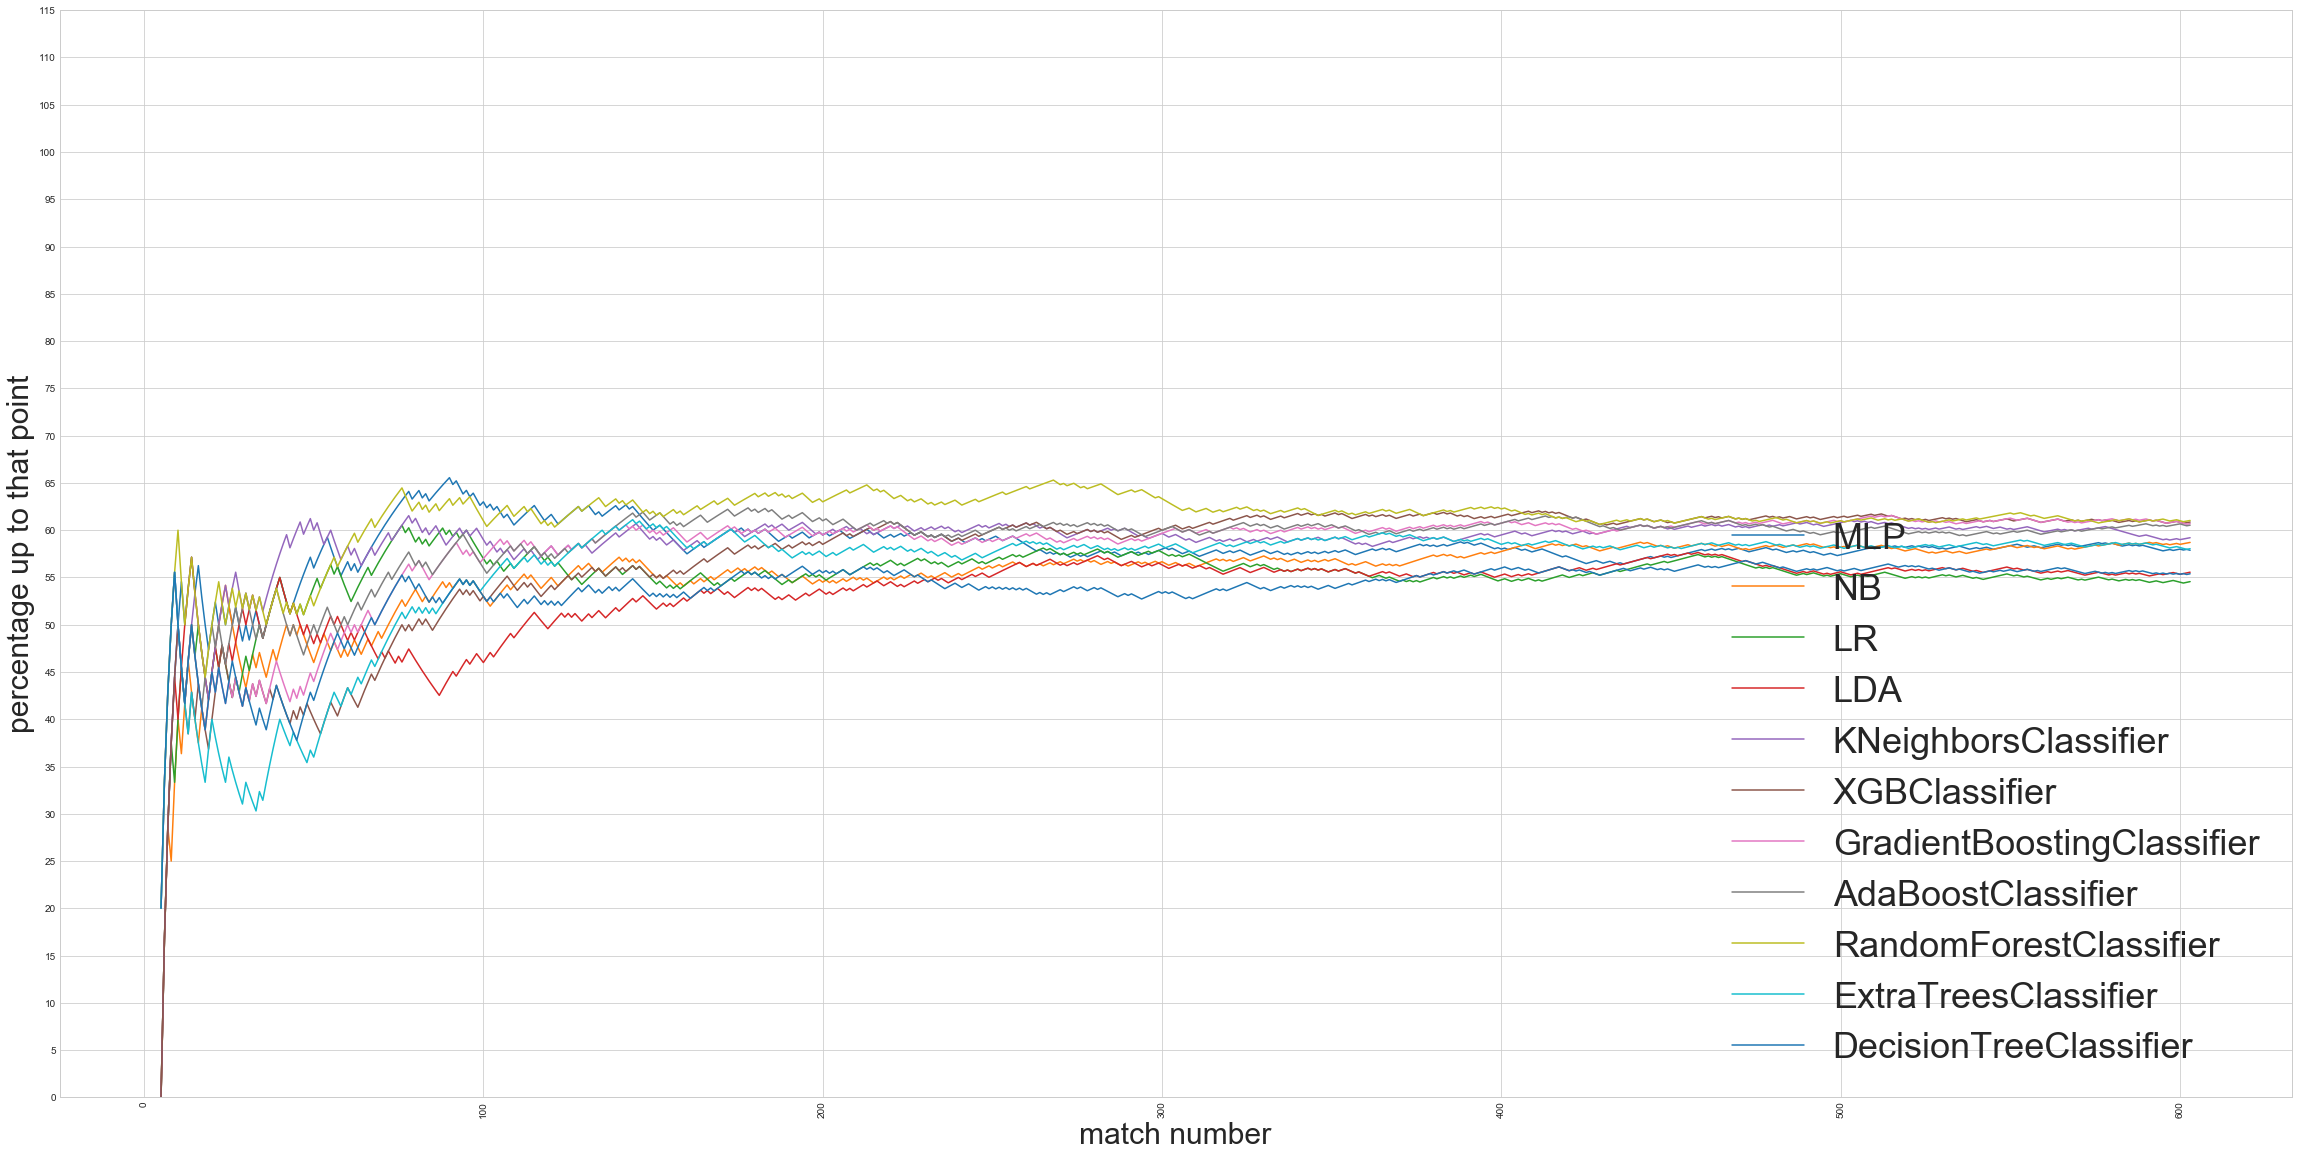

In [271]:
plt.figure(figsize=(40, 20))# people who registered on that day
plt.plot(g_scores.index, g_scores.MLP.values/g_scores.index * 100, label = 'MLP' )
plt.plot(g_scores.index, g_scores.NB.values/g_scores.index * 100, label = 'NB' )
plt.plot(g_scores.index, g_scores.LR.values/g_scores.index* 100, label = 'LR')
plt.plot(g_scores.index, g_scores.LDA.values/g_scores.index* 100,label = 'LDA')
plt.plot(g_scores.index, g_scores.KNeighborsClassifier.values/g_scores.index* 100, label = 'KNeighborsClassifier' )
plt.plot(g_scores.index, g_scores.XGBClassifier.values/g_scores.index* 100, label = 'XGBClassifier')
plt.plot(g_scores.index, g_scores.GradientBoostingClassifier.values/g_scores.index* 100,label = 'GradientBoostingClassifier')
plt.plot(g_scores.index, g_scores.AdaBoostClassifier.values/g_scores.index* 100, label = 'AdaBoostClassifier' )
plt.plot(g_scores.index, g_scores.RandomForestClassifier.values/g_scores.index* 100, label = 'RandomForestClassifier')
plt.plot(g_scores.index, g_scores.ExtraTreesClassifier.values/g_scores.index* 100,label = 'ExtraTreesClassifier')
plt.plot(g_scores.index, g_scores.DecisionTreeClassifier.values/g_scores.index* 100,label = 'DecisionTreeClassifier')
plt.legend(loc='lower right',prop={'size': 36})
plt.yticks(np.arange(0, 120, 5))
plt.xticks(rotation='vertical')
plt.ylim(ymin=0)
plt.xlabel('match number',size =30)
plt.ylabel('percentage up to that point',size = 30)


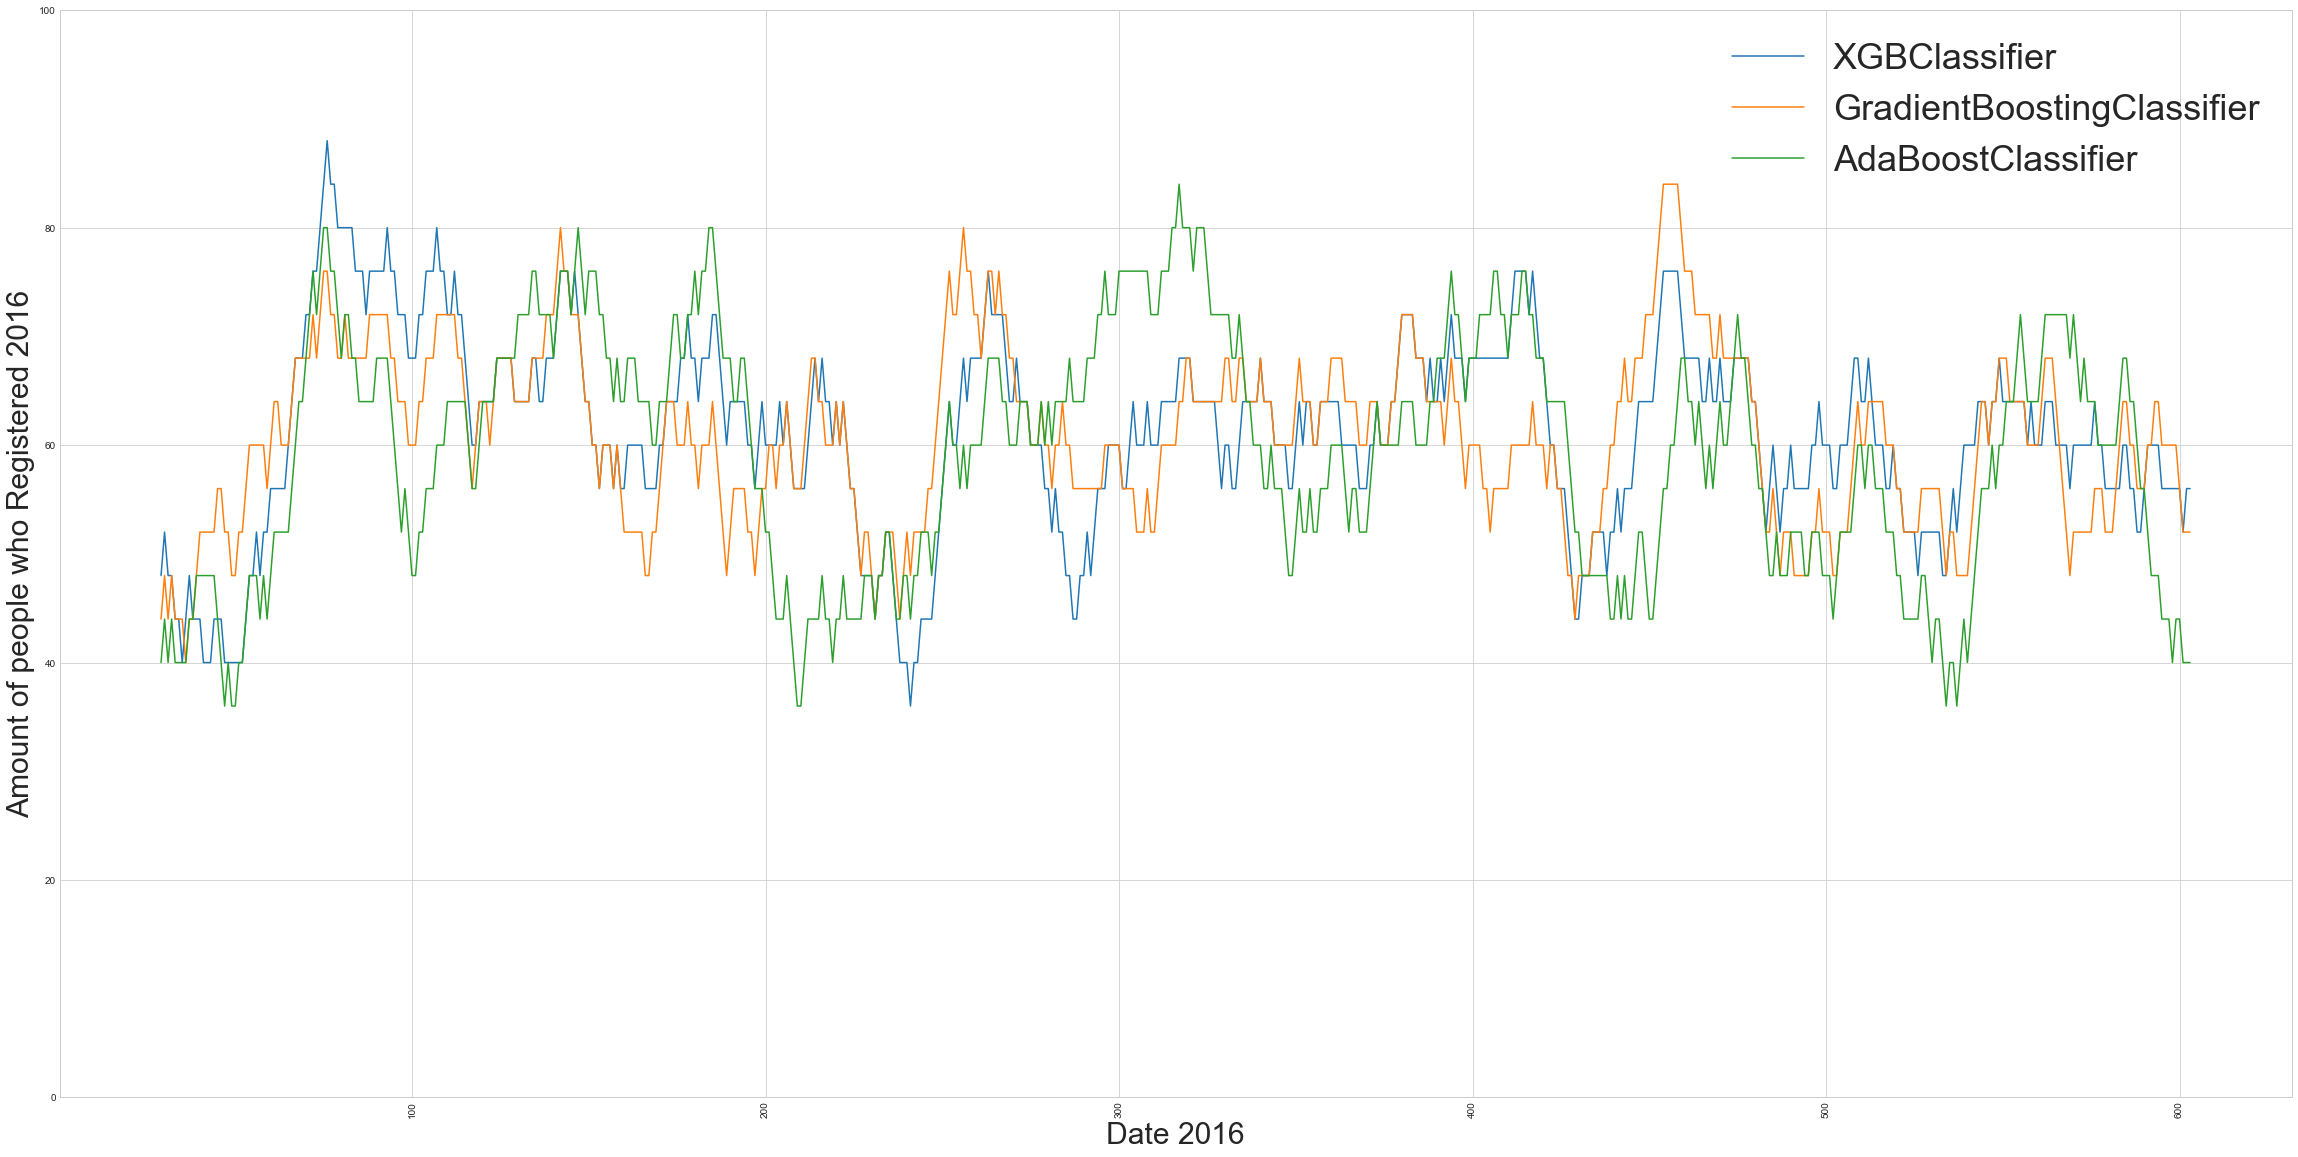

In [224]:
plt.figure(figsize=(40, 20))# people who registered on that day
#plt.plot(big_scores.index, big_scores.MLP.values * 100, label = 'MLP' )
#plt.plot(big_scores.index, big_scores.NB.values *100, label = 'NB' )
#plt.plot(big_scores.index, big_scores.LR.values *100, label = 'LR')
#plt.plot(big_scores.index, big_scores.LDA.values *100,label = 'LDA')
#plt.plot(big_scores.index, big_scores.KNeighborsClassifier.values *100, label = 'KNeighborsClassifier' )
plt.plot(big_scores.index, big_scores.XGBClassifier.values *100, label = 'XGBClassifier')
plt.plot(big_scores.index, big_scores.GradientBoostingClassifier.values *100,label = 'GradientBoostingClassifier')
plt.plot(big_scores.index, big_scores.AdaBoostClassifier.values *100, label = 'AdaBoostClassifier' )
#plt.plot(big_scores.index, big_scores.RandomForestClassifier.values *100, label = 'RandomForestClassifier')
#plt.plot(big_scores.index, big_scores.ExtraTreesClassifier.values *100,label = 'ExtraTreesClassifier')
#plt.plot(big_scores.index, big_scores.DecisionTreeClassifier.values *100,label = 'DecisionTreeClassifier')
plt.legend(loc='top left',prop={'size': 36})
plt.yticks(np.arange(0, 120, 20))
plt.xticks(rotation='vertical')
plt.ylim(ymin=0)
plt.xlabel('Date 2016',size =30)
plt.ylabel('Amount of people who Registered 2016',size = 30)

In [272]:
estimator = xgb.XGBClassifier()
rfe = RFE(estimator)
fit = rfe.fit(X,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 47
Feature Ranking: [11  1  1  1  1  1 22  1 14 41 43  7  1  1  1  1  1  1  1  1  1 23 34  2  1
 42  1  1  1  1  1 27  1  1  6 36 47 37  1 45 17 48 30  1 26 28 24  1  1  1
  1  1  1 40 46  1 10  8 39  1  1  1 18  1 16 35  1  1  3  1 25 49  1  1 12
  1  1  5  9  1 32 20  1 21 19 13 31  1 33 38 44 29 15  1  4]


In [277]:
top_47_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_47_important_features.append(b)
        print b,X.columns[b]

1 ADR
2 Rating2.0
3 first_kills_sum_dr
4 who_kill_who_sum_dr
5 awp_kills_sum_dr
7 seang@res
12 Brehze
13 CeRq
14 daps
15 AnJ
16 USTILO
17 NAF
18 AZR
19 jks
20 Nifty
24 coldzera
26 allu
27 mixwell
28 Magisk
29 friberg
30 HS
32 reltuC
33 nahtE
38 Drone
43 Stewie2K
47 ryx
48 seb
49 CONNOR93
50 bee
51 yeL
52 PKL
55 chelo
59 horvy
60 zakk
61 ANDROID-X23
63 yay
66 LILMAN
67 RUSH
69 tarik
72 Twistzz
73 EliGE
75 LUCAS1
76 kNgV-
79 cadiaN
82 vice
87 shz
93 Grt


In [198]:
estimator = xgb.XGBClassifier()
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(X,y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

NameError: name 'kfold' is not defined

In [1054]:
for a in range(0, len(models)):
    model1 = models[a]
    for b in range(a+1, len(models)):
        model2 = models[b]
        for c in range(b+1, len(models)):
            model3 = models[c]
            estimators = []
            estimators.append(model1)
            estimators.append(model2)
            estimators.append(model3)
            ensemble = VotingClassifier(estimators, voting='soft')
            results = model_selection.cross_val_score(ensemble, X, y, cv=kfold, scoring= scoring)
            if results.mean() > .69:
                print(model1[0], model2[0], model3[0],results.mean(), results.std())

KeyboardInterrupt: 